# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 1 - Smoothers and Generalized Additive Models



**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner


<hr style="height:2pt">

Student: Natalya Levitan

### Homework 1 is due February 6th

In [102]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [103]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from pandas.plotting import scatter_matrix

# Seaborn visualization library
import seaborn as sns


<hr style="height:2pt">

### Problem 1 - Modeling Seasonality of Airbnb Prices
In this problem, the task is to build a regression model to predict the price of an Airbnb rental for a given date. The data are provided in `calendar_train.csv` and `calendar_test.csv`, which contain availability and price data for a sample of Airbnb units in the Boston area from 2017 to 2018, about 4 observations per day in each set.

Start by loading the data using pandas.  
*Hint*: You likely want to have pandas parse the `date` column as a datetime object via the `parse_dates` argument of `pd.read_csv`

In [104]:
#your code here
df_train = pd.read_csv('calendar_train.csv', parse_dates= True)
df_test = pd.read_csv('calendar_test.csv', parse_dates= True)

df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

df_train.head()


,listing_id,date,available,price
123,20872145,4/2/18,t,62.0
124,20872145,4/1/18,t,59.0
125,20872145,3/31/18,t,75.0
126,20872145,3/30/18,t,71.0
127,20872145,3/28/18,t,51.0


In [105]:
df_train.describe()

,listing_id,price
count,3.092880e+05,309288.000000
mean,1.185732e+07,238.780612
std,6.716094e+06,188.527983
min,3.781000e+03,15.000000
25%,5.940866e+06,115.000000
50%,1.302981e+07,190.000000
75%,1.815527e+07,299.000000
max,2.122836e+07,5993.000000


In [106]:
df_train['date']=pd.to_datetime(df_train['date'])
df_train['weekday'] = pd.Series(df_train.date).dt.weekday_name
df_test['date']=pd.to_datetime(df_test['date'])
df_test['weekday']=pd.Series(df_train.date).dt.weekday_name



df_test

,listing_id,date,available,price,weekday
0,21205442,2018-09-28,t,138.0,NaN
1,5166870,2018-08-11,t,210.0,NaN
12,19455818,2018-04-13,t,869.0,NaN
14,20351854,2017-12-23,t,239.0,NaN
17,20622324,2018-02-09,t,259.0,NaN
...,...,...,...,...,...
314566,14415125,2018-09-19,t,250.0,NaN
314567,2843445,2018-05-11,t,85.0,NaN
314568,17591837,2017-12-10,t,199.0,NaN
314570,5075267,2017-12-30,t,188.0,NaN


In [107]:
df_train['date_month']=df_train['date'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S').date())
#df_test['date']=df_test['date'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S').date())

In [108]:
df_train['month']=df_train['date_month'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y-%m-%d').month)

### Exploratory Analysis

Visualize the average price by month and day of the week (i.e., Monday, Tuesday, etc.) for the training set. Point out any trends you notice and explain whether or not they make sense.

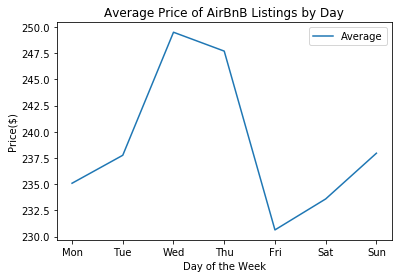

In [109]:
date=[]
avg_price=[]
median_price=[]
b=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
for i in df_train['weekday'].unique():
    date.append(i)
    avg_price.append(df_train[df_train['weekday'] == i]['price'].mean())
plt.plot(range(len(avg_price)), avg_price, label= "Average")
#plt.bar(range(len(avg_price)), avg_price, label= "Average",)
plt.xticks(range(len(avg_price)),b)
plt.ylabel('Price($)')
plt.xlabel('Day of the Week')
plt.title('Average Price of AirBnB Listings by Day')
plt.legend()

* The price during the week - being high probably is explained by the usage of these airbnb for conferences, usually the conference schedule is for Tues-Thurs, on Friday it declines and picks up again for the weekend. The trend increasing towards the weekend makes sense but the prices exceeeding weekend prices - can probably be explained by business travelers. Since these prices are an aggregation of months of data, I am not sure why there would be a spike of prices during the week *

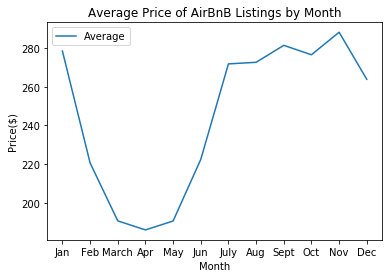

In [110]:
date=[]
avg_price=[]

months=['Jan','Feb','March','Apr','May','Jun','July','Aug','Sept','Oct','Nov','Dec']
for i in df_train['month'].unique():
    date.append(i)
    avg_price.append(df_train[df_train['month'] == i]['price'].mean())
plt.plot(range(len(avg_price)), avg_price, label= "Average")
#plt.bar(range(len(avg_price)), avg_price, label= "Average",)
plt.xticks(range(len(avg_price)),months)
plt.ylabel('Price($)')
plt.xlabel('Month')
plt.title('Average Price of AirBnB Listings by Month')
plt.legend()

* The prices decrease in January, after the holidays, April being the lowest - I would say "season".  Perhaps there are no events or conferences, for which people come but after, as the weather warms up, the visitor number picks up - going into the summer, which is probably the best season, spikes around Thansgiving and then steadily decreases
* The period between December and February, shows an increase in prices, which is expected as it holds the Christmas Day and the New Year’s Eve and Day.

* Overall, the off-peak period for Boston’s Airbnb occurs during the months of February and March and the peak period occurs between April and October in 2019. Prices go down in November until the trend goes up again in December.

### Explore different regression models

Fit a regression model that uses the date as a predictor and predicts the price of an Airbnb rental on that date. In this section, you should ignore all other predictors besides the date. Fit the following models on the training set, and compare the $R^2$ of the fitted models on the test set. Include plots of the fitted models for each method.

*Hint*: You may want to convert the `date` column into a numerical variable by taking the difference in days between each date and the earliest date in the column.

1. Fit simple polynomial models of degree 2, 3, 5, and 8 to the training data. Provide train and test R^2 scores and provide plot(s) of a) the daily averages and b) each model's predictions.

2. You should see that the degree 8 polynomial's predictions are awful- either nonsensically near zero [or far too large] at many input values. This isn't just simple overfitting. What is going wrong in this model, and how might it be addressed?

3. Fit a Smoothing spline model in `pygam` with the smoothness parameter chosen by cross-validation on the training set. Provide the train and test scores of the best-performing model, and plot its predictions. Also plot the predictions of models with more and less smoothing. When plotting the smooths, show a scatterplot of the daily averages on the same axes, for context.

4. Of the models, which performs the best? What is the effect of the tuning parameters (degree and smoothness penalty)?

### 1.1 
#### Changing the format of the dates

In [111]:
df_train = pd.read_csv('calendar_train.csv', parse_dates= True)
df_train.dropna(inplace=True)
df_train['date']=pd.to_datetime(df_train['date'])
df_test = pd.read_csv('calendar_test.csv', parse_dates= True)
df_test.dropna(inplace=True)
df_test['date']=pd.to_datetime(df_test['date'])
df_train.head(5)

,listing_id,date,available,price
123,20872145,2018-04-02,t,62.0
124,20872145,2018-04-01,t,59.0
125,20872145,2018-03-31,t,75.0
126,20872145,2018-03-30,t,71.0
127,20872145,2018-03-28,t,51.0


In [112]:
df_test.head(5)

,listing_id,date,available,price
0,21205442,2018-09-28,t,138.0
1,5166870,2018-08-11,t,210.0
12,19455818,2018-04-13,t,869.0
14,20351854,2017-12-23,t,239.0
17,20622324,2018-02-09,t,259.0


In [113]:
df_test.dtypes

listing_id             int64
date          datetime64[ns]
available             object
price                float64
dtype: object

In [114]:
#Subtracting early date from train set
earli_date = min(df_train['date'])
earli_date
df_train['date_delta']=(df_train['date'].apply(lambda x: x - earli_date)).dt.days
df_train['date_delta'] = (df_train['date_delta']).astype(float)
df_train.head(5)

,listing_id,date,available,price,date_delta
123,20872145,2018-04-02,t,62.0,178.0
124,20872145,2018-04-01,t,59.0,177.0
125,20872145,2018-03-31,t,75.0,176.0
126,20872145,2018-03-30,t,71.0,175.0
127,20872145,2018-03-28,t,51.0,173.0


In [115]:
#Subtracting early date from test set
earli_date = min(df_test['date'])
earli_date
df_test['date_delta']=(df_test['date'].apply(lambda x: x - earli_date)).dt.days
df_test['date_delta'] = (df_test['date_delta']).astype(float)
df_test.head(5)

,listing_id,date,available,price,date_delta
0,21205442,2018-09-28,t,138.0,357.0
1,5166870,2018-08-11,t,210.0,309.0
12,19455818,2018-04-13,t,869.0,189.0
14,20351854,2017-12-23,t,239.0,78.0
17,20622324,2018-02-09,t,259.0,126.0


In [116]:
df_test.dtypes

listing_id             int64
date          datetime64[ns]
available             object
price                float64
date_delta           float64
dtype: object

In [117]:
#Grouping by date mean
df_train=df_train.groupby(df_train['date']).mean()
df_test=df_test.groupby(df_test['date']).mean()

In [118]:
df_test.head()

,listing_id,price,date_delta
date,,,
2017-10-06,1.184651e+07,340.312500,0.0
2017-10-07,1.181977e+07,375.779412,1.0
2017-10-08,1.185502e+07,297.661654,2.0
2017-10-09,1.307946e+07,281.650000,3.0
2017-10-10,1.257350e+07,263.392344,4.0


In [119]:
X = df_train['date_delta']
y = df_train['price']
X= X.values.reshape(-1, 1)
y= y.values.reshape(-1, 1)

In [120]:
X_test = df_test['date_delta']
y_test = df_test['price']
X_test= X_test.values.reshape(-1, 1)
y_test= y_test.values.reshape(-1, 1)

### 1. Polynomials

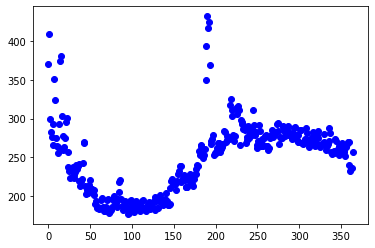

In [121]:
#Train set
plt.scatter(X, y, color = 'blue')


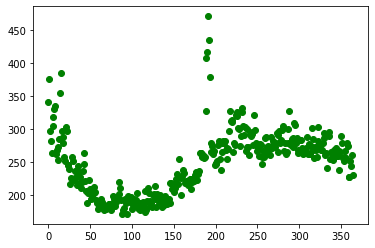

In [122]:
#Testing 
plt.scatter(X_test, y_test, color = 'green')

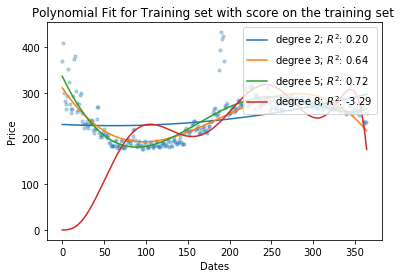

In [123]:
#Modeling on Training set with prediction of Training set
# Polynomial Regression-nth order
plt.scatter(X, y, s=10, alpha=0.3)

for degree in [2, 3, 5, 8]:

    model = make_pipeline(PolynomialFeatures(degree), LinearRegression(fit_intercept=False))

    model.fit(X,y)

    y_plot = model.predict(X) #x_test

    plt.plot(X, y_plot, label="degree %d" % degree +'; $R^2$: %.2f' % model.score(X, y))
plt.legend(loc='upper right')
plt.xlabel("Dates")
plt.ylabel("Price")
plt.title("Polynomial Fit for Training set with score on the training set ")
plt.show()

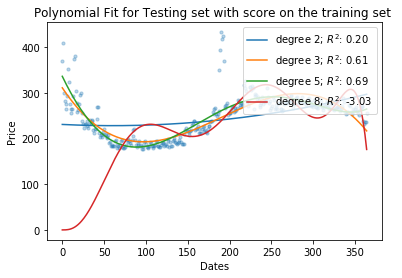

In [124]:
#Modeling on Training set with prediction of Testing set
# Polynomial Regression-nth order
plt.scatter(X, y, s=10, alpha=0.3)

for degree in [2,3,5, 8]:

    model = make_pipeline(PolynomialFeatures(degree), LinearRegression(fit_intercept=False))

    model.fit(X,y)

    y_plot = model.predict(X_test) #x_test

    plt.plot(X, y_plot, label="degree %d" % degree

             +'; $R^2$: %.2f' % model.score(X_test, y_test))

plt.legend(loc='upper right')
plt.xlabel("Dates")
plt.ylabel("Price")
plt.title("Polynomial Fit for Testing set with score on the training set ")

plt.show()

* For both of the traiininig and testing sets, the best performing model has a degree 5 and for both degree 8 is odd (negative valuee)

### 2. Degree 8 oddity
You should see that the degree 8 polynomial's predictions are awful- either nonsensically near zero [or far too large] at many input values. This isn't just simple overfitting. What is going wrong in this model, and how might it be addressed?

* Model with degree 8 is much more inaccurate ( negative value), comparing to the othere models. The oddity is due to numerical instability. With larger degree of polynomial the value grows large for the the current  value.  It can be addressed by converting float64 to float256, or by standardizing x value so they don't become too large as the polynomiial degree increases *

### 3. Smoothing spline model with the smoothness parameter chosen by cross-validation on the training set.

Fit a Smoothing spline model in pygam with the smoothness parameter chosen by cross-validation on the training set. Provide the train and test scores of the best-performing model, and plot its predictions. Also plot the predictions of models with more and less smoothing. When plotting the smooths, show a scatterplot of the daily averages on the same axes, for context.

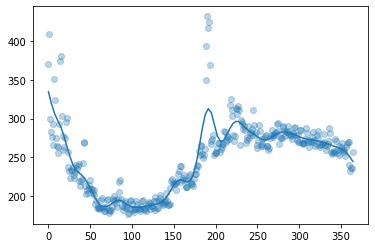

In [125]:
gam = LinearGAM(s(0,lam=1), n_splines=50).fit(X, y)
x_grid = gam.generate_X_grid(term=0)
plt.scatter(X, y, alpha=0.3)
plt.plot(x_grid, gam.predict(x_grid))

In [126]:
smooth_factor =[0, 0.01, 0.1, 1, 5,10,20,200]
kf = KFold(n_splits=5,  shuffle=False)
scores = np.zeros((5, len(smooth_factor)))
df = df_train.sort_values(by='date_delta') 
df_test_ = df_test.sort_values(by='date_delta')
smooth_models={}

for i, (train_index, test_index) in enumerate(kf.split(df)):
    train_df = df.iloc[train_index,:]
    test_df = df.iloc[test_index,:]
    
    for j, cur_smoothing in enumerate(smooth_factor):
        cur_model =LinearGAM(lam=cur_smoothing).fit(train_df['date_delta'], train_df['price'])
        scores[i,j] = r2_score(test_df['price'], cur_model.predict(test_df['date_delta']))
        smooth_models[cur_smoothing]=cur_model

score = np.mean(scores, axis=0)

score

array([-1.12522357e+03, -3.03471319e+01, -1.72310139e+00, -1.37776729e+00,
       -1.17173523e+00, -7.79515430e-01, -4.92039924e-01, -4.51482187e+00])

In [127]:
best_score=smooth_factor[np.argmax(score)]
best_train_score = r2_score(df['price'], smooth_models[20].predict(df['date_delta']))
best_test_score = r2_score(df_test_['price'], smooth_models[20].predict(df_test_['date_delta']))
print ('Best Model to use with lambda ', best_score)
print ('Best Model Train Score ', best_train_score)
print ('Best Model Test Score ', best_test_score)


Best Model to use with lambda  20
Best Model Train Score  0.7353084993820576
Best Model Test Score  0.7061618200497581


### Part 1b: Adapting to weekends

It is possible/likely that prices on weekends (Friday nights and Saturday nights) are systematically higher than prices on weekdays, and that including this aspect of the data-generating process in our model will produce a better fit.

5. Create a binary indicator of weekend versus non-weekend, and include it in your best-performing model from above. How does it impact the model's performance?  
*Hint*: include a categorical variable in a GAM by importing and using `pygam.f` in the same way you've used `pygam.s` for continuous variables.


In [128]:
##weekend indicator df['WEEKDAY'] = np.where((df['DATE']).dt.dayofweek) < 5,0,1)
df_train['weekend']=np.where(df_train['date_delta'].isin(['Friday', 'Saturday']),'1','0')
df_test['weekend']=np.where(df_test['date_delta'].isin(['Friday', 'Saturday']),'1','0')


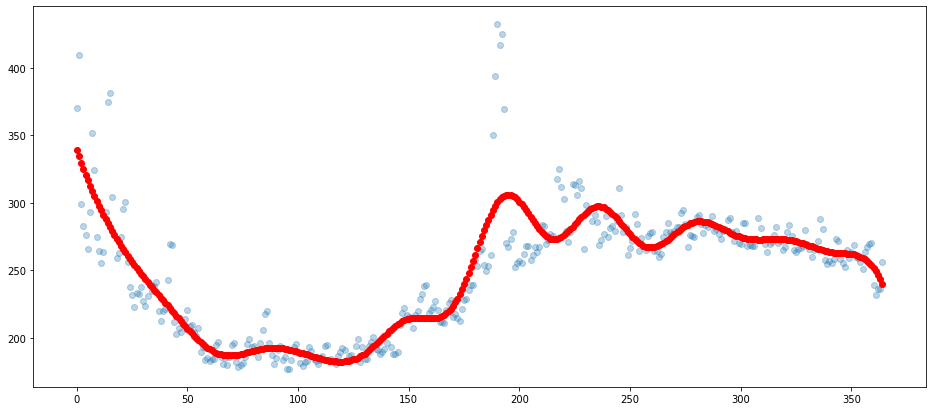

In [129]:
bin_gam = LinearGAM(s(0)+f(1), lam=0).fit(df_train[['date_delta', 'weekend']], df_train[['price'] ])
fig, ax= plt.subplots(1,1, figsize=(16,7))
#daily avreage
ax.scatter(df_train.date_delta, df_train.price, alpha=0.3, label = "originial av data")
#predictions with biniary outcoe
ax.scatter(df_train[['date_delta']], bin_gam.predict(df_train[['date_delta', 'weekend']]), color='r', label = "predicted data")



In [130]:
df_train.head()

,listing_id,price,date_delta,weekend
date,,,,
2017-10-06,1.322575e+07,370.173410,0.0,0
2017-10-07,1.258238e+07,409.298701,1.0,0
2017-10-08,1.217451e+07,299.128713,2.0,0
2017-10-09,1.232258e+07,282.768908,3.0,0
2017-10-10,1.227489e+07,275.933202,4.0,0


In [131]:
 formula1="price~weekend"

model_new=sm.ols(formula=formula1, data=df_train)

In [132]:
fit_model=model_new.fit()
#calculate r squared
x_train_pred=pd.DataFrame({'weekend':df_train['weekend'], 'days':df_train['date_delta']})
x_test_pred=pd.DataFrame({'weekend':df_test['weekend'], 'days':df_test['date_delta']})

In [133]:
y_pred_train =fit_model.predict(x_train_pred)
y_pred_test =fit_model.predict(x_test_pred)

y_pred_train_output =fit_model.get_prediction(x_train_pred).summary_frame()
y_pred_test_output = fit_model.get_prediction(x_test_pred).summary_frame()

r2_train = r2_score(df_train['price'], y_pred_train)
r2_test = r2_score(df_test['price'], y_pred_test)

In [134]:
print(r2_train, r2_test)

0.0 -0.0004490142380144668


These are not very good scores for the weekends, I assume the weekends are not very good predictors of booking

### Part 1c: Going the Distance

You may have noticed from your scatterplots of average price versus day on the training set that there are a few days with abnormally high average prices.

Sort the training data in decreasing order of average price, extracting the 10 most expensive dates. Why are the prices on these days so high? Is it something about the days themselves, noise, an artifact of data collection, or something else?

In [135]:
ten_dates=df_train.sort_values(by=['price'], ascending=False).head(10)
ten_dates.index.sort_values()

DatetimeIndex(['2017-10-06', '2017-10-07', '2017-10-13', '2017-10-20',
               '2017-10-21', '2018-04-13', '2018-04-14', '2018-04-15',
               '2018-04-16', '2018-04-17'],
              dtype='datetime64[ns]', name='date', freq=None)

Interpretation:
*Usually, spike in prices is associated with an event or a weekend.  In this case, April 16th, 2018 was Boston Marathon so people came from out of town to participate, I assume, they booked more than one day which means April 13-April 17th.  
I had search for other events or weekends in Boston for October 6,7th and 13, 20,21st, but I wasn't able to find a particular event or a conference that was taking place.
On a side note, I used to run airbnb apartment in New York - my exprieence was the price always spiked on weekends and for particularly large events (gay pride or july 4th or thanksgiving). But that would be my interpretation of data: when a large amount of people coming to town, the availability of apartments decreases and the price increases.  The cost (price) for the weekend would always be higher than the weekday, and the dates shown are the weekends*


### Problem 2: Predicting Airbnb Rental Price Through Listing Features

In this problem, we'll continue our exploration of Airbnb data by predicting price based on listing features. The data can be found in `listings_train.csv` and `listings_test.csv`.

First, visualize the relationship between each of the predictors and the response variable. Does it appear that some of the predictors have a nonlinear relationship with the response variable?

In [136]:
#https://airbnb-pricing-prediction.herokuapp.com
list_train = pd.read_csv('listings_train.csv', parse_dates= True)
list_test = pd.read_csv('listings_test.csv', parse_dates= True)

In [137]:
list_train.shape, list_train.isnull().mean()

((4370, 12), host_total_listings_count    0.0
 room_type                    0.0
 latitude                     0.0
 longitude                    0.0
 bathrooms                    0.0
 bedrooms                     0.0
 beds                         0.0
 price                        0.0
 security_deposit             0.0
 cleaning_fee                 0.0
 availability_365             0.0
 number_of_reviews            0.0
 dtype: float64)

In [138]:
#checking for null or missing values in the train or testing dataset
list_train.isnull().values.any(), list_test.isnull().values.any()

(False, False)

In [139]:
cts_cols=['availability_365','cleaning_fee','host_total_listings_count','latitude','longitude', 'number_of_reviews','security_deposit']
cat_cols = ['room_type', 'bathrooms','bedrooms','beds']


In [140]:
x=list_train.groupby('room_type')['price'].mean()
x

room_type
Entire home/apt    131.785740
Private room       240.884076
Shared room        242.333333
Name: price, dtype: float64

#### Visualizing Predictors for the Training Dataset

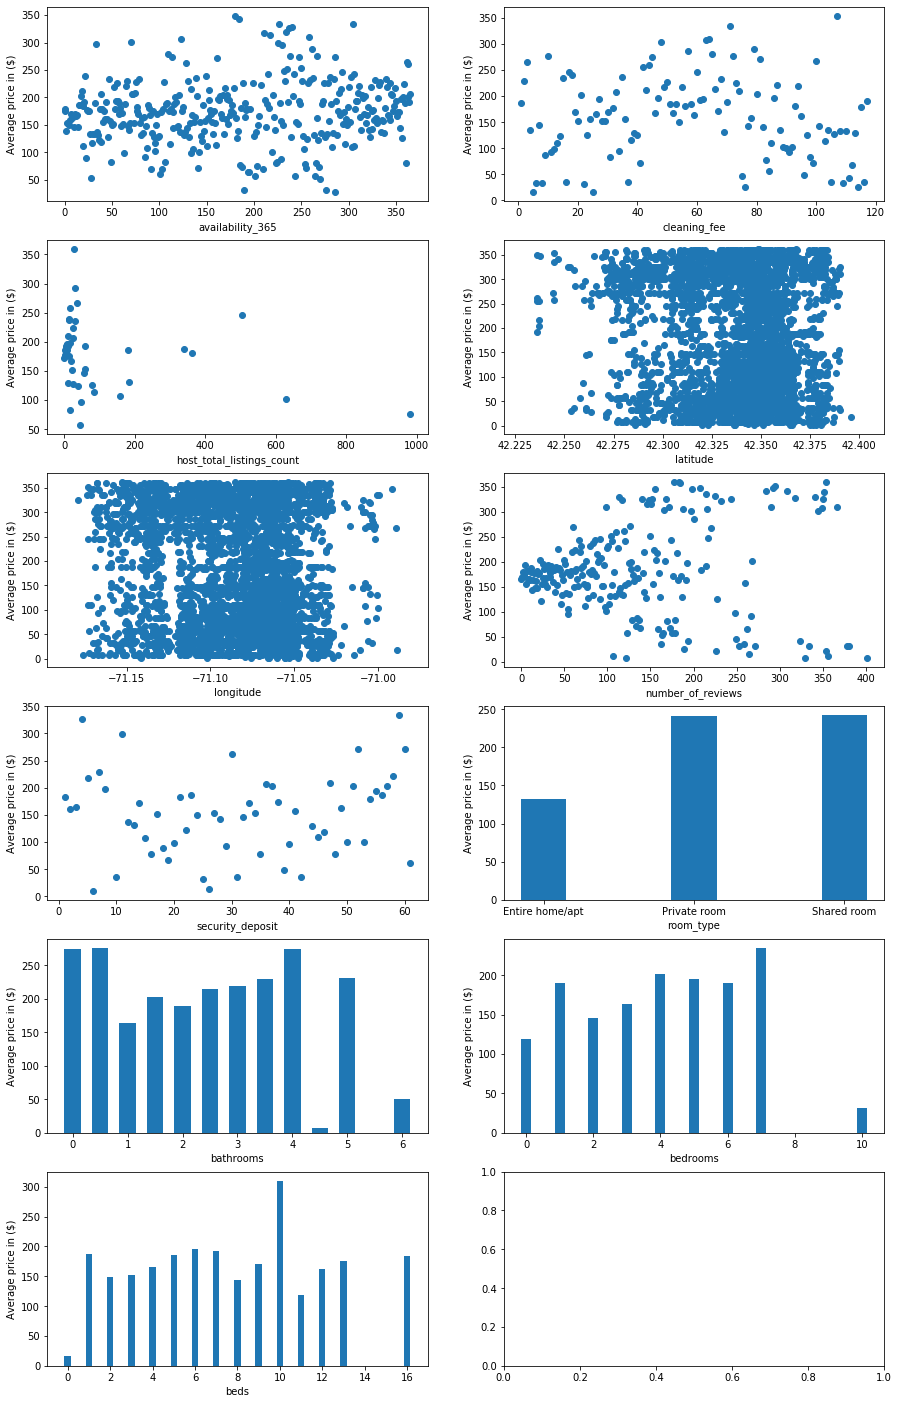

In [141]:
fig4, ax4 = plt.subplots(6,2, figsize=(15,25))
ax4=ax4.flatten()
for i in range (len(cts_cols)):
    ax4[i].scatter(list_train.groupby(cts_cols[i])['price'].mean().index, list_train.groupby(cts_cols[i])['price'].mean())
    ax4[i].set_xlabel(cts_cols[i])
    ax4[i].set_ylabel("Average price in ($)")
    
for i in range (len(cat_cols)):
    ax4[i+7].bar(list_train.groupby(cat_cols[i])['price'].mean().index, 
    list_train.groupby(cat_cols[i])['price'].mean(), align='center', width=0.3)
    ax4[i+7].set_xlabel(cat_cols[i])
    ax4[i+7].set_ylabel("Average price in ($)")
    

First, visualize the relationship between each of the predictors and the response variable. Does it appear that some of the predictors have a nonlinear relationship with the response variable?

#### Interpretation Training Dataset:

1. Average price appears to have a nonlinear relationship with cleaning fee, number of reviews, hosting listing count and security deposit
2. The price is not dependent on the location (attitude and longitude)
3. The ordered categorical variables (bathrooms, bedrooms and beds) have linear relationship with price + outliers which makes sense, as the size of the place would affect how much the host chargesfor the place. *

#### Visualizing Predictors for the Testing Dataset

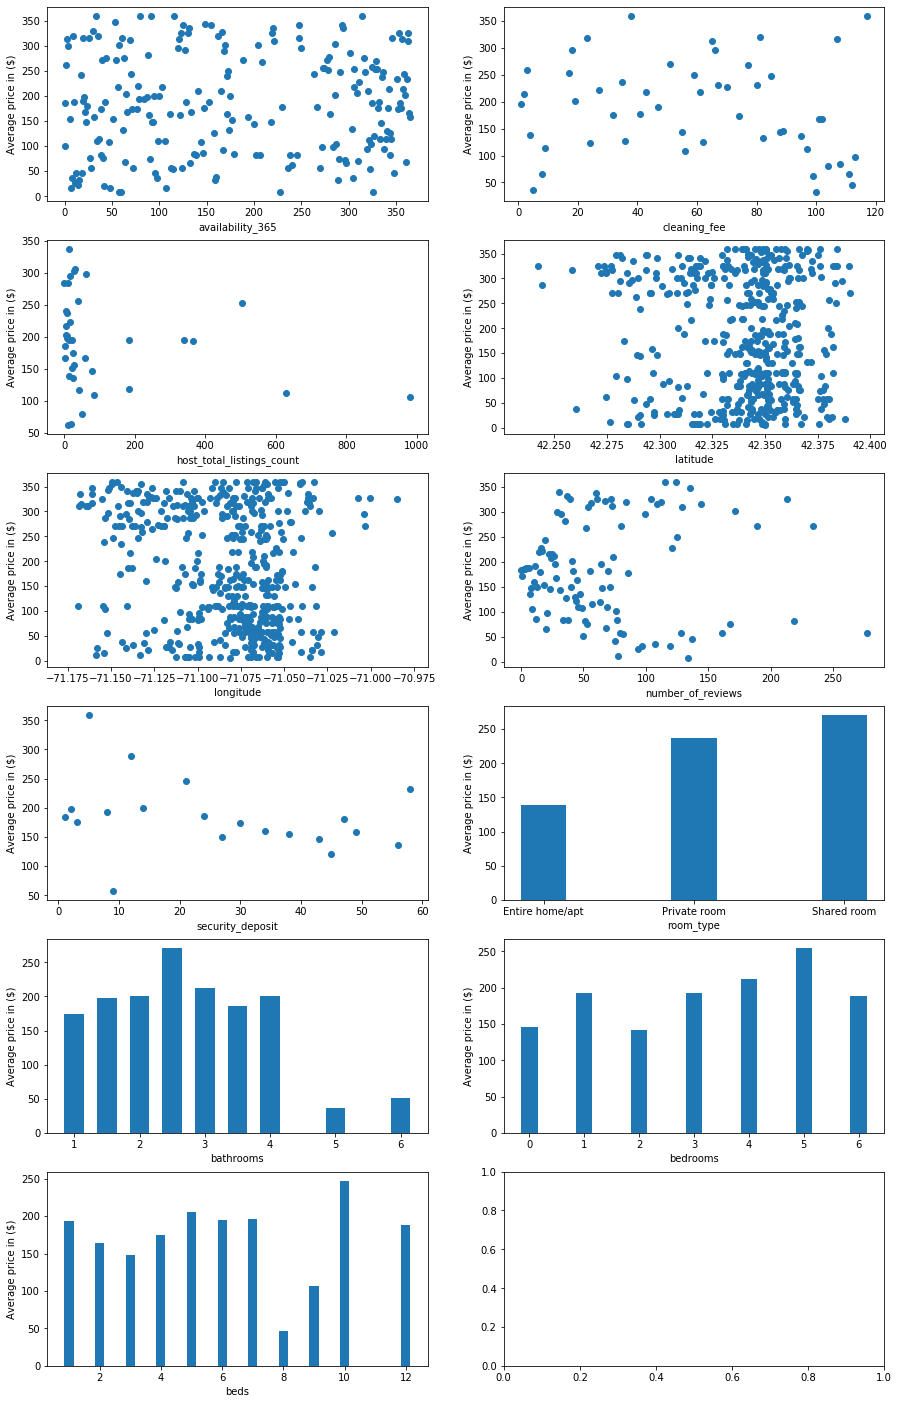

In [142]:
fig4, ax4 = plt.subplots(6,2, figsize=(15,25))
ax4=ax4.flatten()
for i in range (len(cts_cols)):
    ax4[i].scatter(list_test.groupby(cts_cols[i])['price'].mean().index, list_test.groupby(cts_cols[i])['price'].mean())
    ax4[i].set_xlabel(cts_cols[i])
    ax4[i].set_ylabel("Average price in ($)")
    
for i in range (len(cat_cols)):
    ax4[i+7].bar(list_test.groupby(cat_cols[i])['price'].mean().index, 
    list_test.groupby(cat_cols[i])['price'].mean(), align='center', width=0.3)
    ax4[i+7].set_xlabel(cat_cols[i])
    ax4[i+7].set_ylabel("Average price in ($)")
    

#### Interpretation Testing Dataset:

The averages and dependencies are similar to the testing dataset, just with fewer points

#### Scatter Matrix
Checking for collinearity and visualize relationship between each predictor and price.
Scatter matrix using 'kde' for the diagonal (instead of the default histogram)

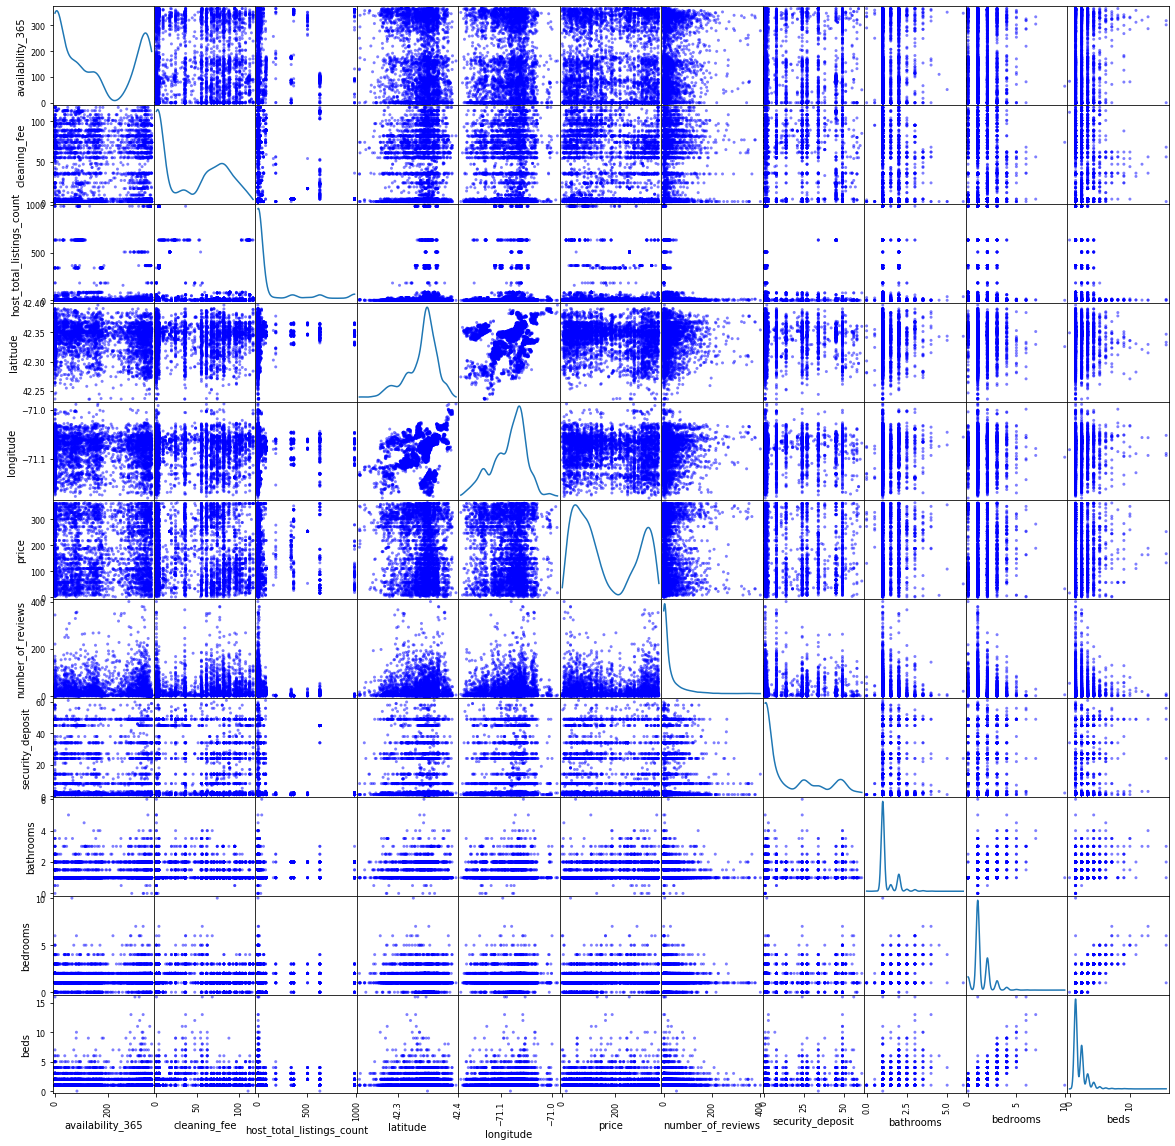

In [143]:
all_cols = ['availability_365','cleaning_fee','host_total_listings_count','latitude','longitude', 'price','number_of_reviews','security_deposit','room_type', 'bathrooms','bedrooms','beds']
axs = scatter_matrix(list_train[all_cols], figsize=(20, 20), c='blue',  diagonal='kde')

Latitude is correlated with logitute, and bedrooms correlated with bathrooms and beds which just
describes the regular layout of the houses - not very insightful - cannot see strong correlatiion with 
price for any of the predictor variabless.

Of all the predictors in the previous chart, bedrooms bathrooms, and beds have linear relationship with
the price.
The Average price appears to have a nonlinear relationship with cleaning fee, number of reviews, hosting listing count and security deposit
 The price is not dependent on the location (attitude and longitude)
 The ordered categorical variables (bathrooms, bedrooms and beds) have linear relationship with price + outliers which makes sense, as the s
ize of the place would affect how much the host chargesfor the place. *

### Part 2a: Polynomial Regression

Fit the following models on the training set and compare the $R^2$ score of the fitted models on the test set:
    
* Linear regression
* Regression with polynomial basis functions of degree 3 (i.e., basis functions $x$, $x^2$, $x^3$ for each predictor $x$) for quantitative predictors.

In [4]:
#Table to display results
listing_data_r2=pd.DataFrame(columns=['Degree', 'Train', 'Test'], index=[0,1,2])
listing_data_r2['Degree']=['1','poly', 'smoothing spline']

In [5]:
list_train = pd.read_csv('listings_train.csv', parse_dates= True)
list_test = pd.read_csv('listings_test.csv', parse_dates= True)

In [6]:
formula1="price ~ host_total_listings_count+C(room_type)+latitude + longitude+ bathrooms + bedrooms + beds + security_deposit+cleaning_fee+availability_365+number_of_reviews" 

linear_model=sm.ols(formula=formula1, data=list_train).fit()
train_predicted=linear_model.get_prediction(list_train.drop('price', axis=1)).summary_frame()
test_predicted=linear_model.get_prediction(list_test.drop('price', axis=1)).summary_frame()
listing_data_r2['Train'][0] = r2_score(list_train['price'], train_predicted["mean"])
listing_data_r2['Test'][0] =r2_score(list_test['price'], test_predicted["mean"])

listing_data_r2

,Degree,Train,Test
0,1,0.249415,0.184791
1,poly,NaN,NaN
2,smoothing spline,NaN,NaN


In [7]:
formula3="price ~ np.vander(host_total_listings_count,4) +C(room_type)+np.vander(latitude,4) + np.vander(longitude,4)+ np.vander(bathrooms,4) + np.vander(bedrooms,4) + np.vander(beds,4) + np.vander(security_deposit,4)+np.vander(cleaning_fee,4)+np.vander(availability_365,4)+ np.vander(+number_of_reviews,4)" 

linear_model3=sm.ols(formula=formula3, data=list_train).fit()
train_predicted3=linear_model3.get_prediction(list_train.drop('price', axis=1)).summary_frame()
test_predicted3=linear_model3.get_prediction(list_test.drop('price', axis=1)).summary_frame()
listing_data_r2['Train'][1] = r2_score(list_train['price'], train_predicted3["mean"])
listing_data_r2['Test'][1] =r2_score(list_test['price'], test_predicted3["mean"])

listing_data_r2

,Degree,Train,Test
0,1,0.249415,0.184791
1,poly,0.270648,0.237833
2,smoothing spline,NaN,NaN


#### Explanation:
Compare to linear performance, R^2 values are a lot better for the polynomial fit, because they are more complex and more closely approximate quantitative predictors

### Part 2b: Generalized Additive Model (GAM)

1. Do you see any advantage in fitting an additive regression model to these data, compared to the above models?

1. Fit a GAM to the training set, and compare the test $R^2$ of the fitted model to the above models. You may use a smoothing spline basis function on each predictor, with the same smoothing parameter for each basis function, tuned using cross-validation on the training set.

2. Plot and examine the smooth of each predictor for the fitted GAM. What are some useful insights conveyed by these plots?


In [18]:
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder
train = pd.read_csv('listings_train.csv')
test = pd.read_csv('listings_test.csv')
le=LabelEncoder()

In [19]:
le.fit(train['room_type'])
train['room_type']=le.transform(train['room_type'])
test['room_type']=le.transform(test['room_type'])

smoothings=[0,5,10,20,100]
kf = KFold(n_splits=5, random_state=47, shuffle=True)
scores = np.zeros((5, len(smoothings)))

for i, (train_index, test_index) in enumerate(kf.split(train)):
    train_df = train.iloc[train_index,:]
    test_df = train.iloc[test_index,:]
    
    for j, cur_smoothing in enumerate(smoothings):
        cur_model =LinearGAM(f(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10),
                            lam=cur_smoothing).fit(train_df.drop('price', axis=1), train_df['price'])
        scores[i,j] = r2_score(test_df['price'], cur_model.predict(test_df.drop('price', axis=1)))
score = np.mean(scores, axis=0)

best_score=smoothings[np.argmax(score)]
best_spline=LinearGAM(lam=best_score).fit(train.drop('price', axis=1), train['price'])
listing_data_r2['Train'][2]= r2_score(train['price'], best_spline.predict(train.drop('price', axis=1)))
listing_data_r2['Test'][2] = r2_score(test['price'], best_spline.predict(test.drop('price', axis=1)))

In [20]:
listing_data_r2

,Degree,Train,Test
0,1,0.249415,0.184791
1,poly,0.270648,0.237833
2,smoothing spline,0.28453,0.247455


Smoothing spline valuse are better for both training and testing datasets

### Visualizing
3. Plot and examine the smooth of each predictor for the fitted GAM. What are some useful insights conveyed by these plots?

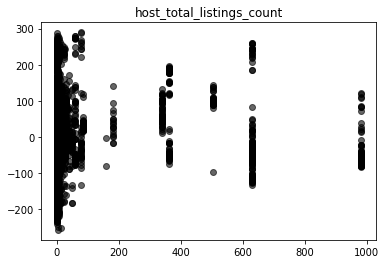

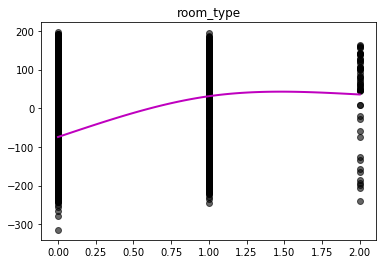

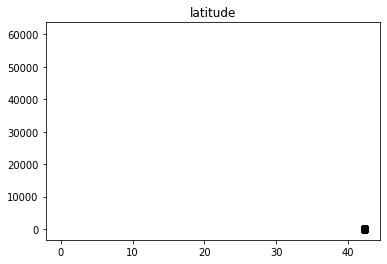

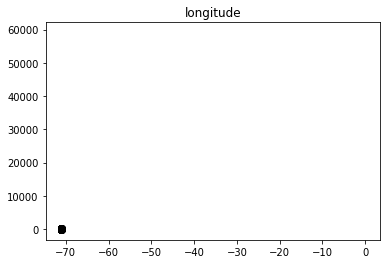

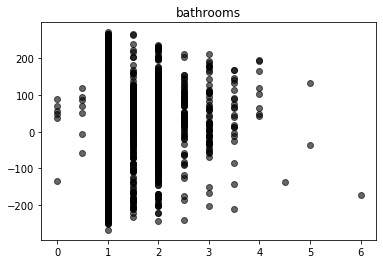

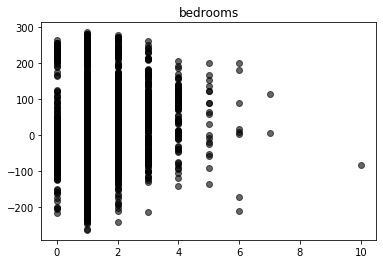

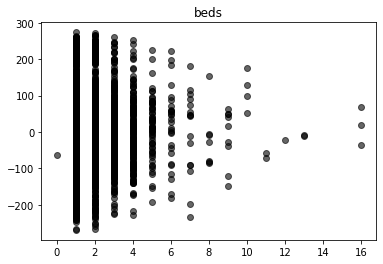

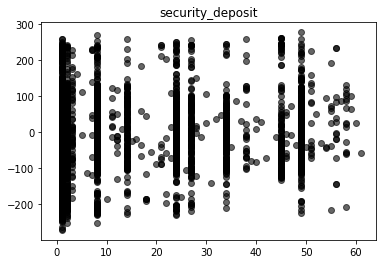

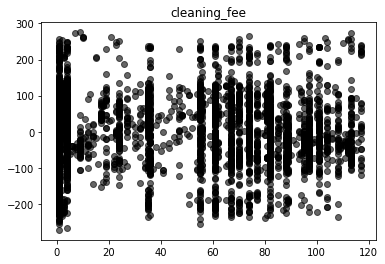

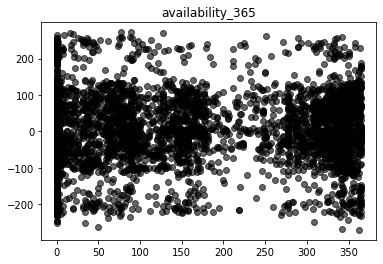

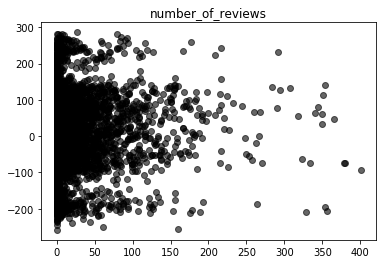

In [21]:
x = train.drop('price', axis=1)
y = train['price']

res = best_spline.deviance_residuals(x,y)
for i, term in enumerate(best_spline.terms):
    if term.isintercept:
        continue
    x_grid = best_spline.generate_X_grid(term=1)
    partial_dep1 = best_spline.partial_dependence(term=i, X=x_grid)
    partial_dep2 = best_spline.partial_dependence(term=i, X=x)
    plt.figure()
    plt.scatter(x.iloc[:, term.feature], partial_dep2 + res, color='k', alpha=0.6)
    plt.plot(x_grid[:, term.feature], partial_dep1, color='m', lw=2)
    plt.title(x.columns.values[term.feature])
    plt.show()

For each of these charts we are looking at the relationship between the features and response variables, and for these the relationship is nonlinear but it seemes the GAMs allow the firt to be more smoothly and more accurately.  You can see the pattern of number of reviewes, availabiility, to be show the nonlinear patterns to be more visually accurate.

There is a number of ways you can interpet, the smoothing spline is going to be more subtle. as long
as its consistening with a data.
Spline can capture local nonlinearity compare to polynomial models. Smoothing spline can find nonlinear 
relationships between the predictor and the response.  Smoothing spline - helping find nonlinear rleatioships
a lineaer fit can fit within confidence itervals.
A few influential points can impact nonlineaerity 

### Part 2c: Putting it All Together
Using the GAM outputs and insights from part 1), discuss the most important variables in the driving prices, and give advide to a frugal traveller hoping to visit Boston.

#### Start with what your data showed, then discuss what your models shohw then you should offer some suggestions

We had tried several methods to understand our data using  linear, polynomial and GAM. We had both categorical and quantitative variables.
With the polynomials, the data showed that the best degree is 5 and that at a larger degree of polynomials the degree of 8 (and larger) was not very useful.
Data exploration allowed us to see some general patterns in pricees:
" * The prices decrease in January, after the holidays, April being the lowest - I would say "season".  Perhaps there are no events or conferences, for which people come but after, as the weather warms up, the visitor number picks up - going into the summer, which is probably the best season, spikes around Thansgiving and then steadily decreases
* The period between December and February, shows an increase in prices, which is expected as it holds the Christmas Day and the New Year’s Eve and Day.
Overall, the off-peak period for Boston’s Airbnb occurs during the months of February and March and the peak period occurs between April and October in 2019. Prices go down in November until the trend goes up again in December."

We visualized correlations between different features and we saw mostly that the relationship is nonlinear between most features and predictors


For a polynomial there if you use orthogonal basis, then you'll have numerical instability as we have seen from the first problem.
If you used orthogonal basis, this problem can be solved, so I dont't see further advantage of using a smoothing spline compare to polynomial model





There is a number of ways you can interpet, the smoothing spline is going to be more subtle. as long
as its consistening with a data.
Spline can capture local nonlinearity compare to polynomial models. Smoothing spline can find nonlinear 
relationships between the predictor and the response.  Smoothing spline - helping find nonlinear rleatioships
a linear fit can fit within confidence itervals.
A few influential points can impact nonlinearity.

Due to the non-linear nature of the data a GAM model might be performing better. 
Furthermore, next to the inclusion of nonlinear effect the GAM also has the advantage that it offers an interpretable solution.

Gams allow to better fit non-linear relationships for each X, and these fitting ar emore accurate for prediictioins of response variable, 
and also for these, the relationships between X and Y can still be viewed individidually. 

To improve: Our data was grouped by and fitted by aggregated data, this reduces its volume, I think to see the more accurate
result that should logically follow that using  GAM is better than polynomials, both our training and testing data would have to bee
modeled with full dataset.

The best advice for frugal traveller:
    * stay in Boston Friday-Sat
    * better prices are in Feb/March or November
    * avoid Boston Marathon
    * Smaller spaces are cheaper than larger spaces
    * the weekends are not very good predictors of booking
    